# exp001_baseline - エラー分析

ベースラインモデルの予測結果とエラー分析を行います。

**実験情報**:
- モデル: LightGBM
- CV: 3-Fold
- 評価指標: MAPE

In [1]:
import sys
from pathlib import Path

# プロジェクトルートをパスに追加
project_root = Path.cwd().parents[2]
sys.path.insert(0, str(project_root / "04_src"))

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォント設定
plt.rcParams['font.family'] = 'Hiragino Sans'
plt.rcParams['axes.unicode_minus'] = False

# スタイル設定
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Project root: {project_root}")

Project root: /Users/kotaro/Desktop/ML/20251122_signamte_mlit


## 1. データ読み込み

In [2]:
# 最新の出力ファイルを取得
output_dir = Path.cwd().parent / "outputs"

# OOF予測ファイル
oof_files = sorted(output_dir.glob("oof_predictions_*.csv"))
latest_oof = oof_files[-1] if oof_files else None
print(f"OOF predictions: {latest_oof.name if latest_oof else 'Not found'}")

# 特徴量重要度ファイル
importance_files = sorted(output_dir.glob("feature_importance_*.csv"))
latest_importance = importance_files[-1] if importance_files else None
print(f"Feature importance: {latest_importance.name if latest_importance else 'Not found'}")

OOF predictions: oof_predictions_20251125_100641.csv
Feature importance: feature_importance_20251125_100641.csv


In [3]:
# OOF予測を読み込み
oof_df = pl.read_csv(latest_oof)
print(f"OOF predictions shape: {oof_df.shape}")
oof_df.head()

OOF predictions shape: (363924, 3)


id,actual,predicted
i64,i64,f64
0,13980000,1.5323e7
1,24480000,1.9794e7
2,24480000,1.7807e7
3,16300000,2.6172e7
4,18800000,2.3218e7


In [4]:
# 特徴量重要度を読み込み
importance_df = pl.read_csv(latest_importance)
print(f"Feature importance shape: {importance_df.shape}")
importance_df.head(10)

Feature importance shape: (106, 2)


feature,importance
str,f64
"""house_area""",1.3322e20
"""post1""",1.2956e20
"""year_built""",1.1328e20
"""money_kyoueki""",6.6728e19
"""addr1_2""",4.2546e19
"""lat""",2.0182e19
"""madori_kind_all""",1.9082e19
"""el""",1.6275e19
"""lon""",1.6194e19


## 2. ErrorAnalyzerによる分析

In [5]:
from evaluation.error_analysis import ErrorAnalyzer

# ErrorAnalyzerを初期化
y_true = oof_df["actual"].to_numpy()
y_pred = oof_df["predicted"].to_numpy()

analyzer = ErrorAnalyzer(y_true, y_pred)
print("ErrorAnalyzer initialized")

ErrorAnalyzer initialized


In [6]:
# 評価指標の計算
metrics = analyzer.calculate_metrics()
print("=" * 50)
print("評価指標")
print("=" * 50)
for k, v in metrics.items():
    if isinstance(v, float):
        print(f"{k}: {v:,.4f}")
    else:
        print(f"{k}: {v}")

評価指標
mape: 28.2933
rmse: 8,952,946.6021
mae: 5,757,230.9921
residual_mean: 3,157.3963
residual_std: 8,952,946.0454
residual_min: -78,111,348.5651
residual_max: 168,641,900.5224


In [7]:
# 残差統計（DataFrameとして返される）
residual_stats_df = analyzer.get_residual_stats()
print("=" * 50)
print("残差統計")
print("=" * 50)
residual_stats_df

残差統計


metric,value
str,f64
"""mean""",3157.396321
"""std""",8.9529e6
"""min""",-7.8111e7
"""25%""",-4.6051e6
"""50%""",-1.0361e6
"""75%""",3.2681e6
"""max""",1.6864e8
"""mape""",28.293265
"""rmse""",8.9529e6


## 3. 価格帯別の分析

In [8]:
# 価格帯セグメントを作成（10分位）
n_segments = 10
price_quantiles = np.percentile(y_true, np.linspace(0, 100, n_segments + 1))
segment_labels = []
for i in range(len(y_true)):
    for j in range(n_segments):
        if price_quantiles[j] <= y_true[i] <= price_quantiles[j + 1]:
            segment_labels.append(f"Q{j+1}")
            break
    else:
        segment_labels.append(f"Q{n_segments}")

segment_col = pl.Series("segment", segment_labels)

# セグメント別分析
segment_analysis = analyzer.analyze_by_segment(segment_col, segment_name="price_segment")
segment_analysis = segment_analysis.sort("segment")
segment_analysis

segment,count,mape,rmse,mae,residual_mean,residual_std
str,u32,f64,f64,f64,f64,f64
"""Q1""",37433,82.905954,6.7517e6,5.6366e6,-5.6297e6,3.7271e6
"""Q10""",35855,21.344406,2.1383e7,1.5217e7,1.1378e7,1.8105e7
"""Q2""",38632,39.189987,5.7509e6,4.2896e6,-4.0181e6,4.1143e6
"""Q3""",33166,25.945836,5.2072e6,3.6821e6,-2.6623e6,4.4753e6
"""Q4""",36819,22.886683,5.2103e6,3.8783e6,-2.1023e6,4.7674e6
"""Q5""",36657,20.712092,5.4678e6,4.1558e6,-1.5986e6,5.2290e6
"""Q6""",36663,17.942328,5.5373e6,4.2446e6,-530787.045347,5.5119e6
"""Q7""",40441,16.099753,5.8782e6,4.4640e6,373146.422808,5.8664e6
"""Q8""",31563,15.860098,6.7019e6,5.1894e6,1.7169e6,6.4784e6


In [9]:
# 価格帯の範囲を追加
segment_ranges = []
for i in range(n_segments):
    low = price_quantiles[i] / 1e6
    high = price_quantiles[i + 1] / 1e6
    segment_ranges.append(f"{low:.1f}M - {high:.1f}M")

print("価格帯の範囲:")
for i, r in enumerate(segment_ranges):
    print(f"  Q{i+1}: {r}")

価格帯の範囲:
  Q1: 4.9M - 9.0M
  Q2: 9.0M - 12.8M
  Q3: 12.8M - 15.5M
  Q4: 15.5M - 18.5M
  Q5: 18.5M - 21.8M
  Q6: 21.8M - 25.0M
  Q7: 25.0M - 29.8M
  Q8: 29.8M - 35.0M
  Q9: 35.0M - 45.0M
  Q10: 45.0M - 188.0M


/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_44163/3696979241.py:26: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_44163/3696979241.py:26: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_44163/3696979241.py:26: UserWarning: Glyph 24111 (\N{CJK UNIFIED IDEOGRAPH-5E2F}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_44163/3696979241.py:26: UserWarning: Glyph 12475 (\N{KATAKANA LETTER SE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_44163/3696979241.py:26: UserWarning: Glyph 12464 (\N{KATAKANA LETTER GU}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_44163/3

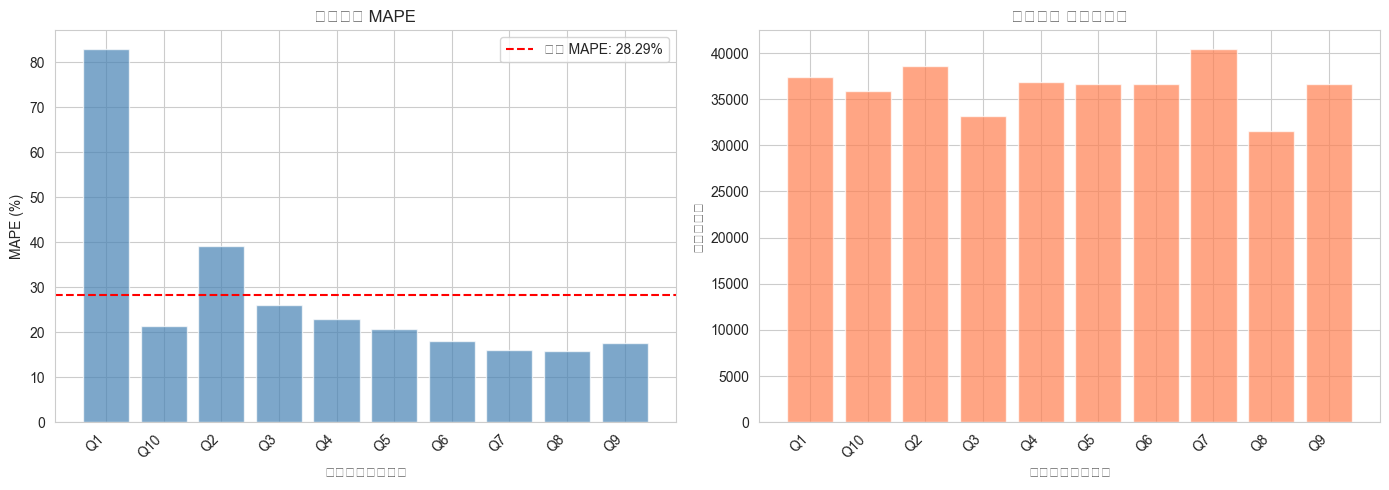

In [10]:
# 価格帯別MAPEの可視化
segment_pd = segment_analysis.to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAPE
ax1 = axes[0]
ax1.bar(range(len(segment_pd)), segment_pd['mape'], color='steelblue', alpha=0.7)
ax1.set_xlabel('価格帯セグメント')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('価格帯別 MAPE')
ax1.set_xticks(range(len(segment_pd)))
ax1.set_xticklabels(segment_pd['segment'], rotation=45, ha='right')
ax1.axhline(y=metrics['mape'], color='red', linestyle='--', label=f'全体 MAPE: {metrics["mape"]:.2f}%')
ax1.legend()

# サンプル数
ax2 = axes[1]
ax2.bar(range(len(segment_pd)), segment_pd['count'], color='coral', alpha=0.7)
ax2.set_xlabel('価格帯セグメント')
ax2.set_ylabel('サンプル数')
ax2.set_title('価格帯別 サンプル数')
ax2.set_xticks(range(len(segment_pd)))
ax2.set_xticklabels(segment_pd['segment'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 4. 残差分布の可視化

/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_44163/2007821373.py:47: UserWarning: Glyph 27531 (\N{CJK UNIFIED IDEOGRAPH-6B8B}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_44163/2007821373.py:47: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_44163/2007821373.py:47: UserWarning: Glyph 30334 (\N{CJK UNIFIED IDEOGRAPH-767E}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_44163/2007821373.py:47: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_44163/2007821373.py:47: UserWarning: Glyph 20870 (\N{CJK UNIFIED IDEOGRAPH-5186}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/i

/Users/kotaro/Desktop/ML/20251122_signamte_mlit/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27531 (\N{CJK UNIFIED IDEOGRAPH-6B8B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kotaro/Desktop/ML/20251122_signamte_mlit/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kotaro/Desktop/ML/20251122_signamte_mlit/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30334 (\N{CJK UNIFIED IDEOGRAPH-767E}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kotaro/Desktop/ML/20251122_signamte_mlit/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kotaro/Desktop/ML/202

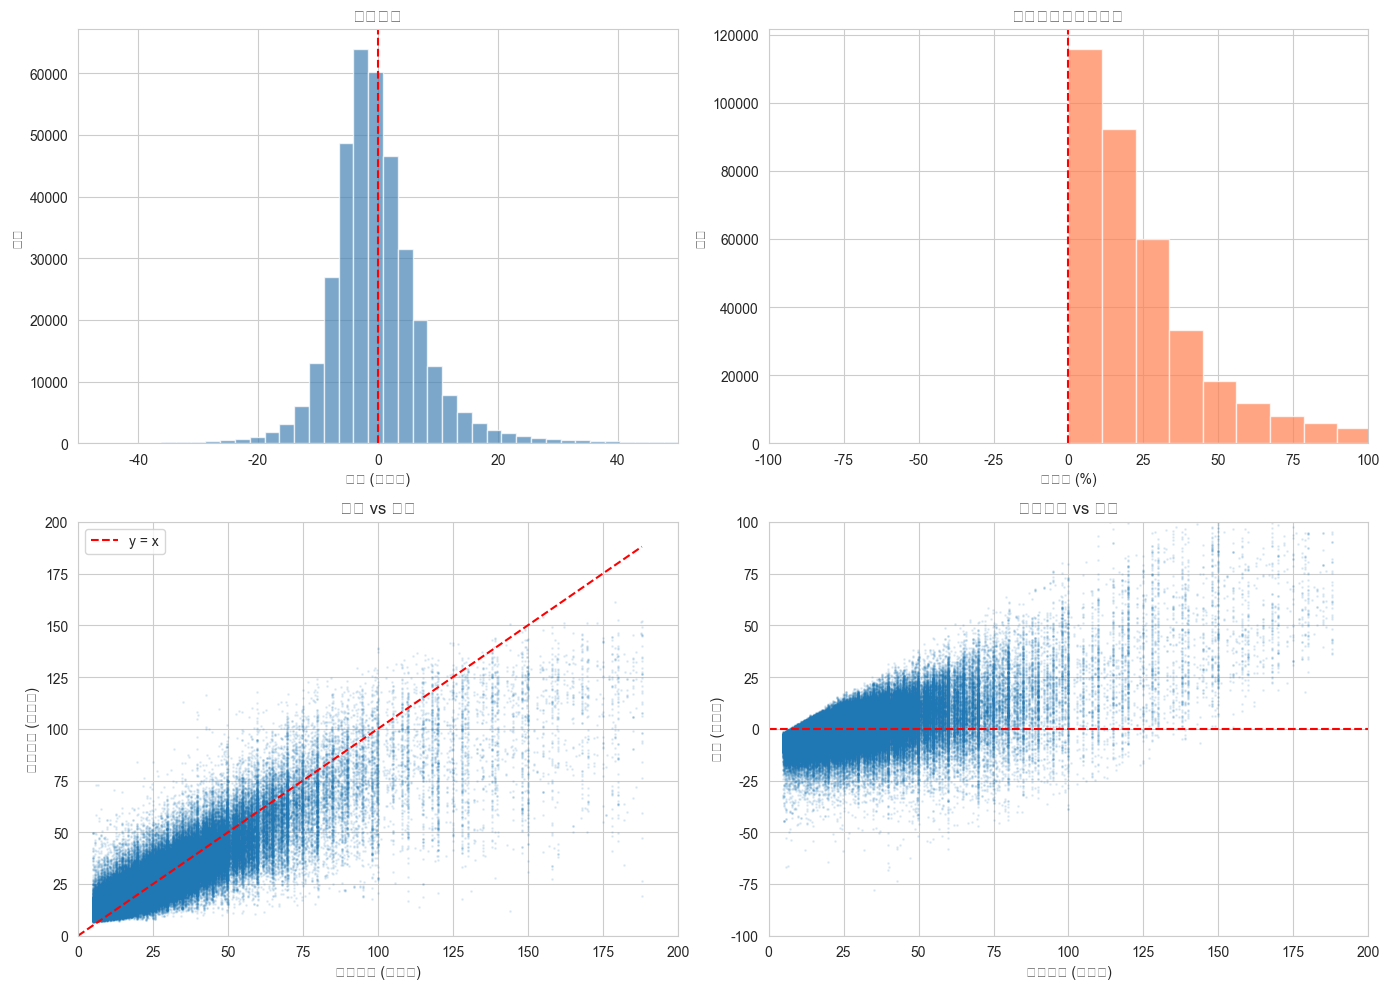

In [11]:
# 残差（予測 - 実績）
residuals = analyzer.residuals
pct_errors = analyzer.pct_errors

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 残差のヒストグラム
ax1 = axes[0, 0]
ax1.hist(residuals / 1e6, bins=100, color='steelblue', alpha=0.7, edgecolor='white')
ax1.axvline(x=0, color='red', linestyle='--')
ax1.set_xlabel('残差 (百万円)')
ax1.set_ylabel('頻度')
ax1.set_title('残差分布')
ax1.set_xlim(-50, 50)

# パーセント誤差のヒストグラム
ax2 = axes[0, 1]
ax2.hist(pct_errors, bins=100, color='coral', alpha=0.7, edgecolor='white')
ax2.axvline(x=0, color='red', linestyle='--')
ax2.set_xlabel('誤差率 (%)')
ax2.set_ylabel('頻度')
ax2.set_title('パーセント誤差分布')
ax2.set_xlim(-100, 100)

# 実績 vs 予測
ax3 = axes[1, 0]
ax3.scatter(y_true / 1e6, y_pred / 1e6, alpha=0.1, s=1)
max_val = max(y_true.max(), y_pred.max()) / 1e6
ax3.plot([0, max_val], [0, max_val], 'r--', label='y = x')
ax3.set_xlabel('実績価格 (百万円)')
ax3.set_ylabel('予測価格 (百万円)')
ax3.set_title('実績 vs 予測')
ax3.set_xlim(0, 200)
ax3.set_ylim(0, 200)
ax3.legend()

# 実績価格 vs 残差
ax4 = axes[1, 1]
ax4.scatter(y_true / 1e6, residuals / 1e6, alpha=0.1, s=1)
ax4.axhline(y=0, color='red', linestyle='--')
ax4.set_xlabel('実績価格 (百万円)')
ax4.set_ylabel('残差 (百万円)')
ax4.set_title('実績価格 vs 残差')
ax4.set_xlim(0, 200)
ax4.set_ylim(-100, 100)

plt.tight_layout()
plt.show()

## 5. 外れ値分析

In [12]:
# 外れ値の検出（標準偏差ベース、3σ）
outlier_indices = analyzer.find_outliers(method='std', threshold=3.0)
print(f"外れ値数（3σ）: {len(outlier_indices)} / {len(y_true)} ({len(outlier_indices)/len(y_true)*100:.2f}%)")

# 外れ値の統計
outlier_residuals = residuals[outlier_indices]
print(f"\n外れ値の残差統計:")
print(f"  平均: {np.mean(outlier_residuals):,.0f}円")
print(f"  標準偏差: {np.std(outlier_residuals):,.0f}円")
print(f"  最小: {np.min(outlier_residuals):,.0f}円")
print(f"  最大: {np.max(outlier_residuals):,.0f}円")

外れ値数（3σ）: 5740 / 363924 (1.58%)

外れ値の残差統計:
  平均: 31,240,639円
  標準偏差: 34,187,092円
  最小: -78,111,349円
  最大: 168,641,901円


In [13]:
# パーセント誤差で外れ値を検出（50%以上の誤差）
large_error_mask = np.abs(pct_errors) > 50
print(f"大きな誤差（50%超）: {large_error_mask.sum()} / {len(y_true)} ({large_error_mask.sum()/len(y_true)*100:.2f}%)")

# 外れ値の詳細
print("\n大きな誤差のサンプル（上位10件）:")
large_error_indices = np.where(large_error_mask)[0]
sorted_by_error = large_error_indices[np.argsort(np.abs(pct_errors[large_error_indices]))[::-1]]

for i, idx in enumerate(sorted_by_error[:10]):
    print(f"  {i+1}. ID={idx}: 実績={y_true[idx]/1e6:.2f}M, 予測={y_pred[idx]/1e6:.2f}M, 誤差={pct_errors[idx]:.1f}%")

大きな誤差（50%超）: 52827 / 363924 (14.52%)

大きな誤差のサンプル（上位10件）:
  1. ID=58924: 実績=5.95M, 予測=72.61M, 誤差=1120.3%
  2. ID=17795: 実績=6.50M, 予測=72.61M, 誤差=1017.0%
  3. ID=267900: 実績=5.00M, 予測=49.77M, 誤差=895.4%
  4. ID=225138: 実績=5.00M, 予測=49.77M, 誤差=895.4%
  5. ID=310915: 実績=5.00M, 予測=49.61M, 誤差=892.1%
  6. ID=356674: 実績=5.00M, 予測=49.61M, 誤差=892.1%
  7. ID=267081: 実績=5.90M, 予測=58.53M, 誤差=892.0%
  8. ID=145775: 実績=5.80M, 予測=49.64M, 誤差=755.8%
  9. ID=333724: 実績=5.00M, 予測=42.30M, 誤差=746.0%
  10. ID=318185: 実績=5.00M, 予測=42.06M, 誤差=741.2%


## 6. 特徴量重要度の可視化

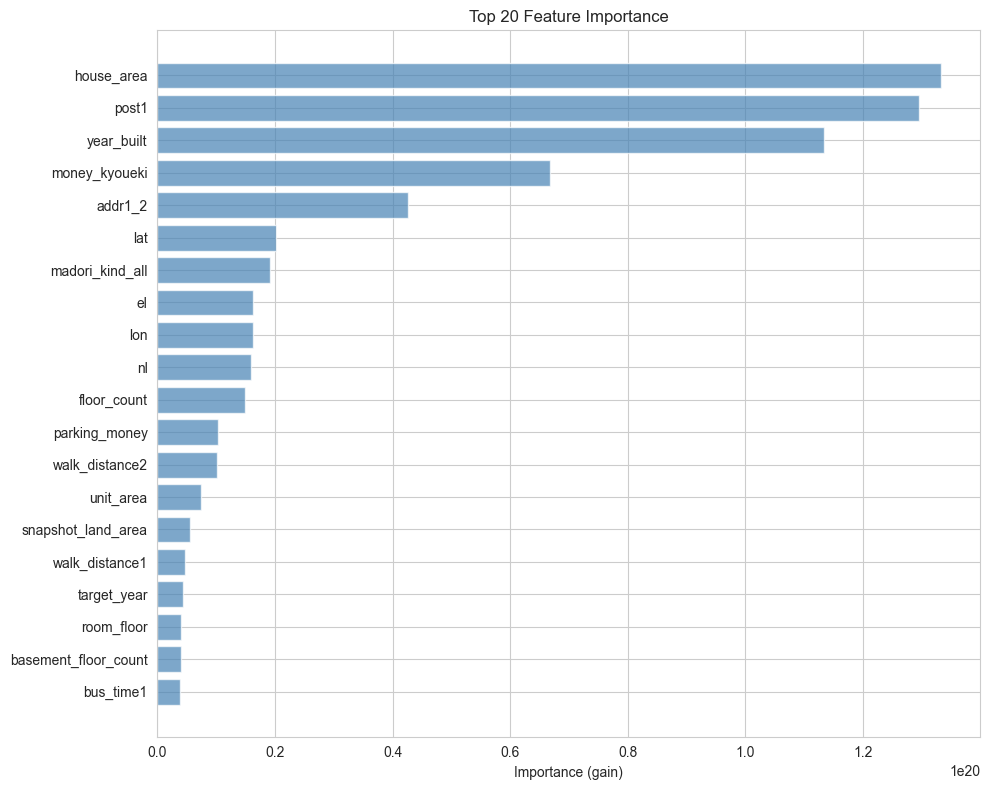

In [14]:
# Top 20 特徴量
top_n = 20
top_features = importance_df.head(top_n).to_pandas()

fig, ax = plt.subplots(figsize=(10, 8))
y_pos = np.arange(len(top_features))

ax.barh(y_pos, top_features['importance'], color='steelblue', alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance (gain)')
ax.set_title(f'Top {top_n} Feature Importance')

plt.tight_layout()
plt.show()

重要度80%に達する特徴量数: 8
重要度95%に達する特徴量数: 19


/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_44163/4232709015.py:21: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_44163/4232709015.py:21: UserWarning: Glyph 24500 (\N{CJK UNIFIED IDEOGRAPH-5FB4}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_44163/4232709015.py:21: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_44163/4232709015.py:21: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_44163/4232709015.py:21: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/i

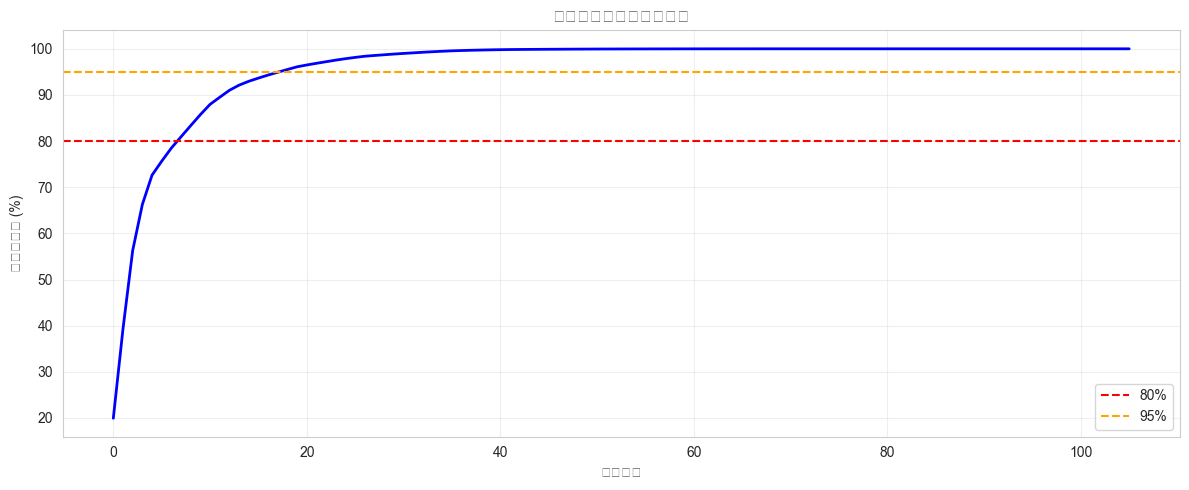

In [15]:
# 特徴量重要度の累積割合
total_importance = importance_df['importance'].sum()
cumsum_importance = importance_df['importance'].cum_sum() / total_importance * 100

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(range(len(cumsum_importance)), cumsum_importance.to_numpy(), 'b-', linewidth=2)
ax.axhline(y=80, color='red', linestyle='--', label='80%')
ax.axhline(y=95, color='orange', linestyle='--', label='95%')
ax.set_xlabel('特徴量数')
ax.set_ylabel('累積重要度 (%)')
ax.set_title('特徴量重要度の累積分布')
ax.legend()
ax.grid(True, alpha=0.3)

# 80%と95%に達する特徴量数を表示
n_80 = int((cumsum_importance < 80).sum()) + 1
n_95 = int((cumsum_importance < 95).sum()) + 1
print(f"重要度80%に達する特徴量数: {n_80}")
print(f"重要度95%に達する特徴量数: {n_95}")

plt.tight_layout()
plt.show()

## 7. サマリー

In [16]:
print("=" * 60)
print("exp001_baseline エラー分析サマリー")
print("=" * 60)
print(f"\n【モデル性能】")
print(f"  MAPE: {metrics['mape']:.4f}%")
print(f"  RMSE: {metrics['rmse']:,.0f}円")
print(f"  MAE:  {metrics['mae']:,.0f}円")

print(f"\n【残差分析】")
print(f"  平均残差: {metrics['residual_mean']:,.0f}円")
print(f"  残差標準偏差: {metrics['residual_std']:,.0f}円")
print(f"  外れ値率（3σ）: {len(outlier_indices)/len(y_true)*100:.2f}%")

print(f"\n【特徴量重要度】")
print(f"  重要度Top 5:")
for i, row in enumerate(importance_df.head(5).iter_rows(named=True)):
    print(f"    {i+1}. {row['feature']}")
print(f"  80%累積に必要な特徴量数: {n_80}")

print(f"\n【改善ポイント】")
# 価格帯別でMAPEが高いセグメントを特定
high_mape_segments = segment_pd[segment_pd['mape'] > metrics['mape'] * 1.2]
if len(high_mape_segments) > 0:
    print(f"  - 高MAPE価格帯: {list(high_mape_segments['segment'])}")
print(f"  - 大誤差（50%超）サンプル: {large_error_mask.sum()}件")
print("=" * 60)

exp001_baseline エラー分析サマリー

【モデル性能】
  MAPE: 28.2933%
  RMSE: 8,952,947円
  MAE:  5,757,231円

【残差分析】
  平均残差: 3,157円
  残差標準偏差: 8,952,946円
  外れ値率（3σ）: 1.58%

【特徴量重要度】
  重要度Top 5:
    1. house_area
    2. post1
    3. year_built
    4. money_kyoueki
    5. addr1_2
  80%累積に必要な特徴量数: 8

【改善ポイント】
  - 高MAPE価格帯: ['Q1', 'Q2']
  - 大誤差（50%超）サンプル: 52827件
